### バンドル調整のサンプル実装

In [1]:
%matplotlib inline
import cv2
import numpy as np
import random
import glob
import math
import pickle
import matplotlib.pyplot as plt # matplotlibの描画系
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#同次座標系に関する関数
def makeHomogeneous(vector):
    rows,cols = vector.shape[:2]
    ones = [np.ones(cols)]
    return np.r_[vector, ones]
    
def delHomogeneous(vector):
    rows,cols = vector.shape[:2]
    val = vector[:rows-1]
    dim = vector[rows-1:]
    return val / dim

def generateM(R, t):
    M = np.eye(4)
    M[:3,:3] = R
    M[:3,3] = t.T
    return M

def invM(M):
    R = M[:3,:3].T
    t = M[:3,3]
    Rt = -R.dot(t)
    newM = np.eye((4))
    newM[:3,:3] = R
    newM[0:3,3] = Rt.T
    return newM

#画像表示に関する関数
def cv_imshow(image):
    show_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(show_img)
    plt.show()

def cv_imshow_gray(gray):
    plt.gray()    
    plt.imshow(gray)
    plt.show()
    
#指定したフォルダ内のパスを取得する
def get_file_list(path, ext):
    files = glob.glob(path + "\*." + ext)
    return files

#ワールド座標系の三次元位置をカメラ位置での正規化座標系に投影する
def get_proj_pos(vec3d_w,M):
    h_vec3d_w = makeHomogeneous(vec3d_w)
    vec3d_c = M.dot(h_vec3d_w)
    vec2d = vec3d_c[0:2,:]
    vec_z = vec3d_c[2,:]
    vec2d = vec2d / vec_z
    return vec2d

In [3]:
#パラメータ設定
circle_interval = 40.0#[mm]
pattern_size = (8, 6)

img_points = []
obj_points = []
obj = []

#objの三次元位置算出
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32 ) #チェスボード（X,Y,Z）座標の指定 (Z=0)
pattern_points[:,:2] = np.indices(pattern_size).T.reshape(-1, 2)
pattern_points *= circle_interval

In [4]:
#画像読み込み
file_list = get_file_list("data/point_marker", "png")

#パターン検出
obj_points = []
img_points = []
for m in file_list:
    gray = cv2.imread(m)
    found, corner = cv2.findCirclesGrid(gray, pattern_size)
    if not found:
        print ('marker not found: ' + m)
        continue
    img_points.append(corner.reshape(-1, 2))   #appendメソッド：リストの最後に因数のオブジェクトを追加
    obj_points.append(pattern_points)
    
    #show_image = cv2.drawChessboardCorners(gray, pattern_size, corner,found)
    #cv_imshow(show_image)


marker not found: data/point_marker\image11.png
marker not found: data/point_marker\image12.png
marker not found: data/point_marker\image14.png


In [5]:
#カメラの内部パラメータを予め求めておく
rms, K, d, r, t = cv2.calibrateCamera(obj_points,img_points,(gray.shape[1],gray.shape[0]), None, None)
print ("RMS = ", rms)
print ("K = \n", K)
print ("d = ", d)

Rs = []
for rvec in r:
    R = cv2.Rodrigues(rvec)[0]
    Rs.append(R)
    
#レンズ歪みを補正しておく
undist_points = []
undist_norm_points = []
for pt in img_points:
    undist_pt = cv2.undistortPoints(np.array([pt]), K, d, P=K)
    undist_norm_pt = cv2.undistortPoints(np.array([pt]), K, d)
    undist_points.append(undist_pt[0])
    undist_norm_points.append(undist_norm_pt[0])

RMS =  0.18170822363792422
K = 
 [[545.8436598    0.         309.40378827]
 [  0.         548.67902185 242.8776044 ]
 [  0.           0.           1.        ]]
d =  [[ 0.0090191  -0.05988521 -0.00162167 -0.00279637  0.00184383]]


In [6]:
g_Rs = Rs
g_Ts = t
obj = pattern_points.T
norm_img_points = undist_norm_points

## 観測データを生成する

#### データ数
num_camera: カメラ数
num_obj: 点の数

#### 真値
- obj: 三次元位置[3 x n]
- g_M: 真のカメラ位置


#### 観測点
- obs: 観測点の三次元位置（初期値) [3 x n]
- obs_M: 観測したカメラ位置（初期値) [カメラID] [4 x 4]
- norm_img_points: 観測した画像上での位置 [カメラID] [m x 3]

In [7]:
norm_K = np.eye(3,3)
norm_d = np.zeros(5)

g_M = []
for R, t in zip(g_Rs, g_Ts):
    g_M.append(generateM(R,t))

#カメラ数等の値を算出する
num_camera = len(g_M)
num_obj = obj.shape[1]
num_fix_camera = 2

#ノイズを乗せた観測データを作成する
obs = obj.copy() #三次元位置（初期値）
mu = 0.0
sigma = 20.0
for pt in obs.T:
    pt[0] += random.gauss(mu, sigma)
    pt[1] += random.gauss(mu, sigma)
    pt[2] += random.gauss(mu, sigma)
    
#ノイズを乗せたカメラ位置を作成する
mu = 0.0
sigma = 20.0
obs_M = []#観測したカメラ位置
count = 0
for R, t in zip(g_Rs, g_Ts):
    if count < num_fix_camera:
        err = np.array([[0,0,0]]).reshape(3,1)
    else:
        err = np.array((random.gauss(mu, sigma), random.gauss(mu, sigma),random.gauss(mu, sigma))).reshape(3,1)
    obs_M.append(generateM(R,t + err))
    count += 1


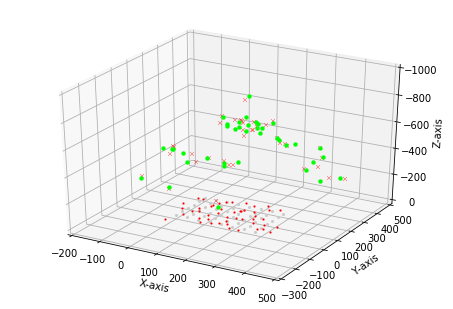

In [8]:
#真のカメラ位置
inv_t = []
for r, t in zip(g_Rs, g_Ts):
    tmp_t = invM(generateM(r, t))[0:3, 3]
    inv_t.append(tmp_t)
g_camera_pos = np.array(inv_t).T

#カメラ位置（誤差あり）    
inv_t = []
for m in obs_M:
    tmp_t = invM(m)[0:3, 3]
    inv_t.append(tmp_t)
obs_camera_pos = np.array(inv_t).T

# グラフ作成
fig = plt.figure()
ax = Axes3D(fig)

# 軸ラベルの設定
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

ax.set_xlim(-200, 500)
ax.set_ylim(-300, 500)
ax.set_zlim(10, -1000)

# グラフ描画
ax.plot(obj[0,:], obj[1,:], obj[2,:], "o", color="#cccccc", ms=3, mew=0.1)
ax.plot(obs[0,:], obs[1,:], obs[2,:], "o", color="#ff0000", ms=2, mew=0.1)
ax.plot(g_camera_pos[0,:], g_camera_pos[1,:], g_camera_pos[2,:], "x", color="#ff0000", ms=4, mew=0.3)
ax.plot(obs_camera_pos[0,:], obs_camera_pos[1,:], obs_camera_pos[2,:], "o", color="#00ff00", ms=4, mew=0.3)

plt.show()

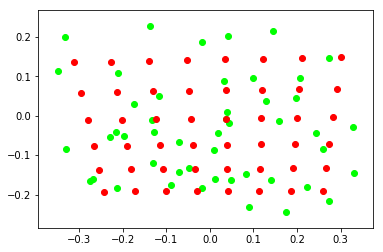

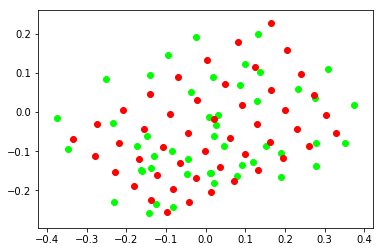

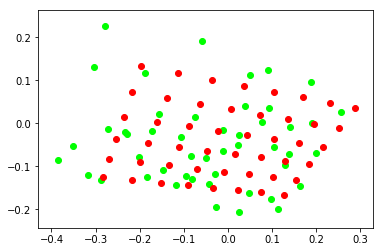

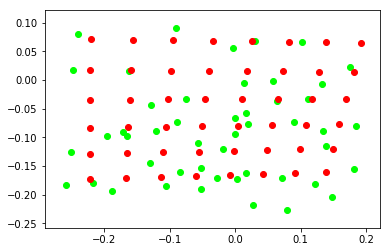

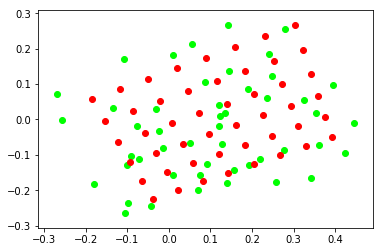

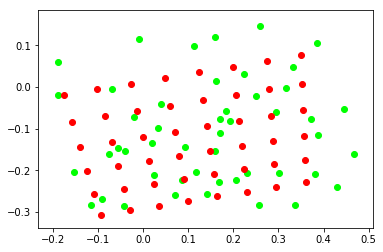

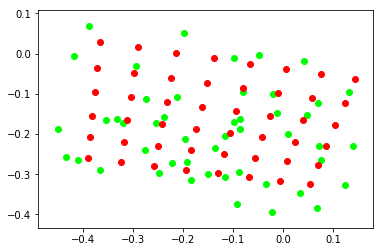

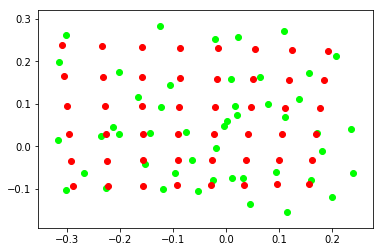

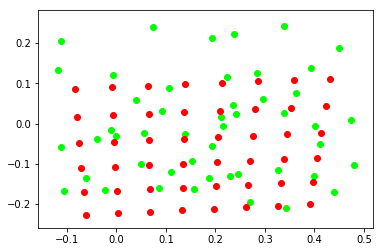

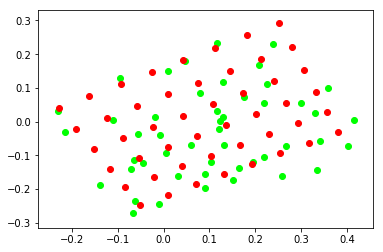

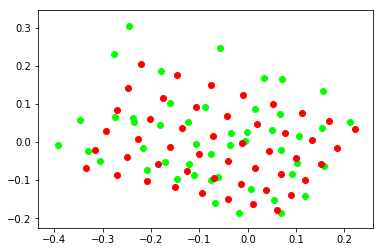

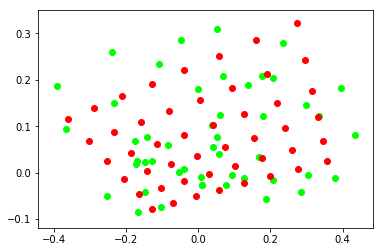

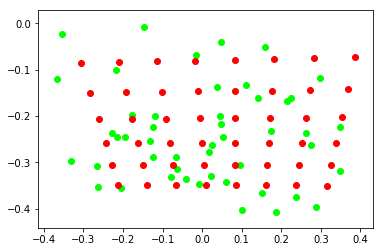

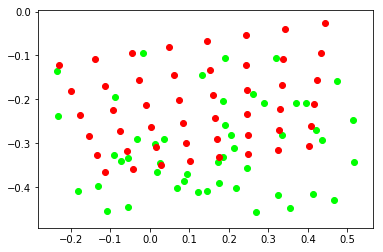

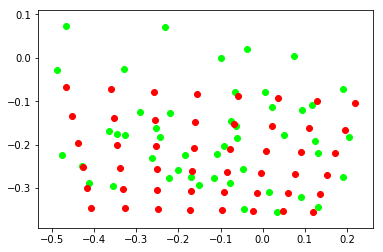

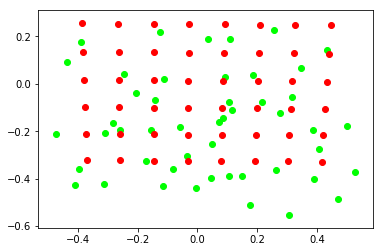

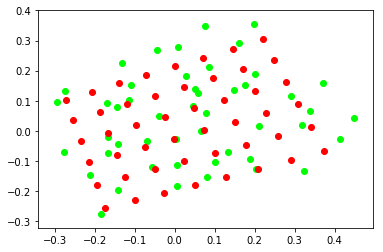

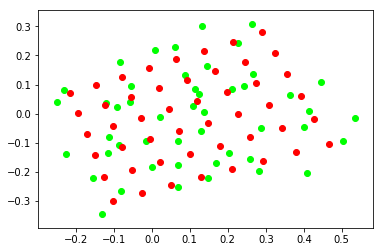

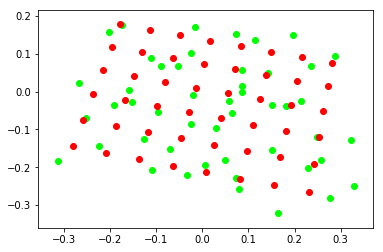

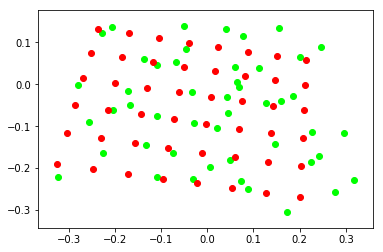

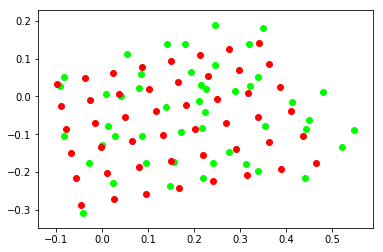

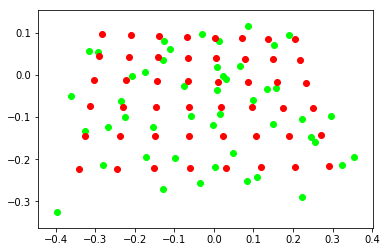

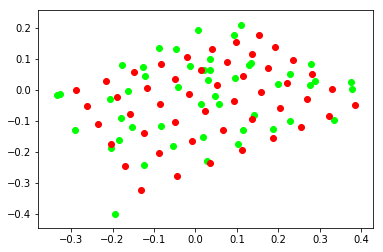

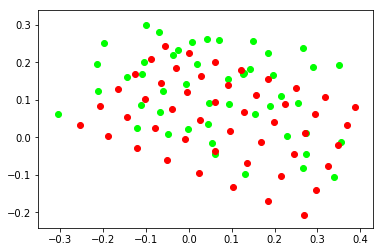

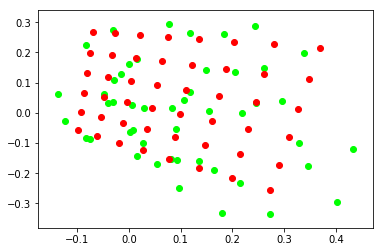

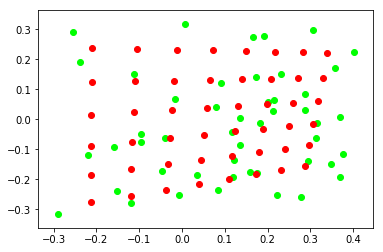

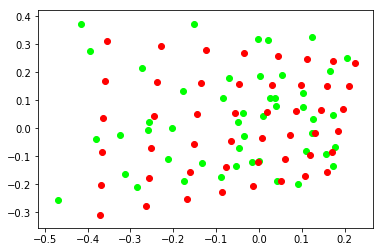

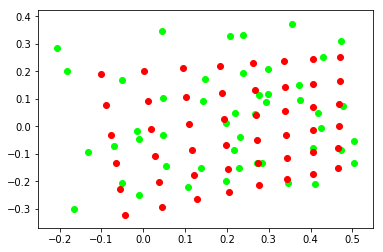

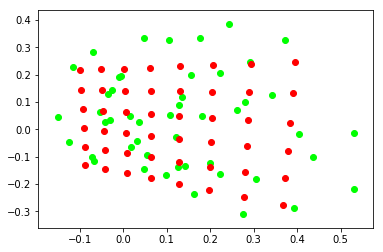

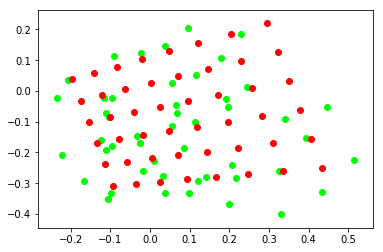

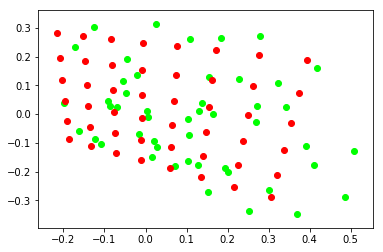

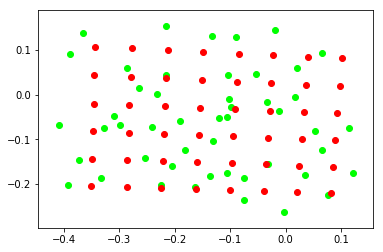

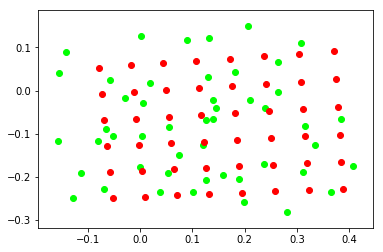

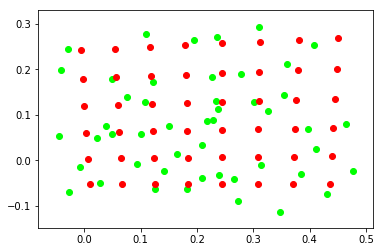

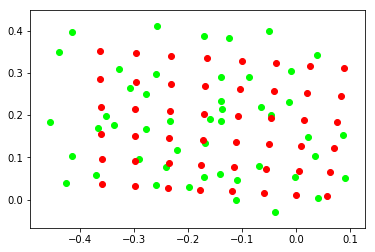

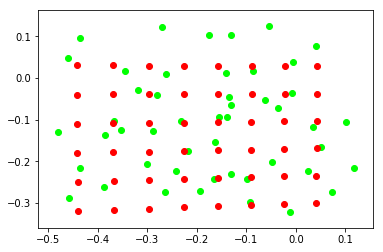

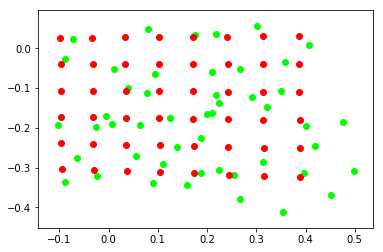

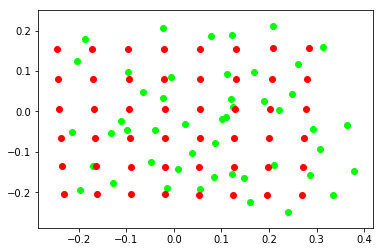

In [9]:
#推定した三次元位置、カメラ位置を投影する例
for i in range(num_camera):
    tmp_cam_num = i
    pos2d = get_proj_pos(obs, obs_M[tmp_cam_num])
    plt.scatter(pos2d[0,:],pos2d[1,:], color="#00ff00")
    plt.scatter(norm_img_points[tmp_cam_num][:,0],norm_img_points[tmp_cam_num][:,1],color="#ff0000")
    plt.show()

### バンドル調整

In [10]:
param_num_camera = 6 * (num_camera - num_fix_camera)
param_num_obj = 3 * num_obj
param_num = param_num_camera + param_num_obj
num_loop = 10

print ("num_camera= " + str(num_camera))
print ("num_obj= " + str(num_obj))
print ("param_camera= " + str(param_num_camera))
print ("param_obj= " + str(param_num_obj))

num_camera= 38
num_obj= 48
param_camera= 216
param_obj= 144


### ヤコビアン計算

画像上の点$\boldsymbol{x_k}=(x,y)$がカメラ$c_1 ... c_n$および三次元点群$p_1 ... p_m$の微小変化によりどのように移動するかを考える。
このとき、ヤコビ行列$J$は
$$ 
\begin{eqnarray}
  J
  &=&
  \left(
  \begin{array}{c,c,c,c,c,c}
  \frac{\delta \boldsymbol{x_1}}{\delta c_1} &
  ... &
  \frac{\delta \boldsymbol{x_1}}{\delta c_n} &
  \frac{\delta \boldsymbol{x_1}}{\delta p_1} &
  ... &
  \frac{\delta \boldsymbol{x_1}}{\delta p_m} &\\
  ...&...&...&...&...&...\\
  \frac{\delta \boldsymbol{x_k}}{\delta c_1} &
  ... &
  \frac{\delta \boldsymbol{x_k}}{\delta c_n} &
  \frac{\delta \boldsymbol{x_k}}{\delta p_1} &
  ... &
  \frac{\delta \boldsymbol{x_k}}{\delta p_m} &\\
  \end{array}
\right)
\end{eqnarray}
$$ 
である。

これらの各項はチェインルールにより以下のように計算することができる。
まず、画像上の点$\boldsymbol{x}=(x,y)$のカメラ$c_1 ... c_n$の微小変化による偏微分を考える。、
$$ 
\begin{eqnarray}
 \frac{\delta \boldsymbol{x}}{\delta c}
 &=&
 \frac{\delta \boldsymbol{x}}{\delta X_c}
 \frac{\delta X_c}{\delta c}\\
 &=&
  \left(
    \begin{array}{c,c,c}
      \frac{1}{Z_c} &
      0 &
      - \frac{x}{Z_c} \\
      0 &
      \frac{1}{Z_c} &
      -\frac{y}{Z_c}
    \end{array}
  \right)
  \left(
    \begin{array}{c,c,c,c,c,c}
      1 & 0 & 0 & 0 & Z_c & - Y_c \\
      0 & 1 & 0 & -Z_c & 0 & X_c \\
      0 & 0 & 1 & Y_c & -X_c & 0
    \end{array}
  \right) \\
 &=&
  \left(
    \begin{array}{c,c,c,c,c,c}
      \frac{1}{Z_c} & 0 & \frac{x}{Z_c} & -xy & 1 + x^2 & - y \\
      0 & \frac{1}{Z_c} & \frac{y}{Z_c} & -1-y^2 & xy & x
    \end{array}
  \right) \\
\end{eqnarray}
$$ 
となる。
なぜなら、
$$
\begin{eqnarray}
  \left(
    \begin{array}{c}
    x \\ y
    \end{array}
  \right) 
  &=&
  \frac{1}{Z_c}
  \left(
    \begin{array}{c}
    X_c \\ Y_c
    \end{array}
  \right)  
\end{eqnarray}
$$ 
より
$$
\begin{eqnarray}
 \frac{\delta \boldsymbol{x}}{\delta X_c}
 &=&
  \left(
    \begin{array}{c,c,c}
      \frac{1}{Z_c} &
      0 &
      - \frac{x}{Z_c} \\
      0 &
      \frac{1}{Z_c} &
      -\frac{y}{Z_c}
    \end{array}
  \right)
\end{eqnarray}
$$
である。また、
$$
\begin{eqnarray}
\boldsymbol{X_c}
&=&
  \left(
    \begin{array}{c,c,c}
    1 & -\Delta \omega_z & \Delta \omega_y \\
    \Delta \omega_z & 1 & ^\Delta \omega_x \\
    - \Delta \omega_y & \Delta \omega_x & 1
    \end{array}
  \right) 
  \hat{\boldsymbol{X_c}} + \Delta t
\end{eqnarray}
$$ 
であることから、
$$
\begin{eqnarray}
 \frac{\delta X_c}{\delta c}
 &=&
  \left(
    \begin{array}{c,c,c,c,c,c}
      1 & 0 & 0 & 0 & Z_c & - Y_c \\
      0 & 1 & 0 & -Z_c & 0 & X_c \\
      0 & 0 & 1 & Y_c & -X_c & 0
    \end{array}
  \right) \\
\end{eqnarray}
$$
である。

次に、画像上の点$\boldsymbol{x}=(x,y)$の三次元点群$p_1 ... p_m$の微小変化による偏微分を考える。

$$
\begin{eqnarray}
 \frac{\delta \boldsymbol{x}}{\delta t_p}
 &=&
 \frac{\delta \boldsymbol{x}}{\delta X_c}
 \frac{\delta \boldsymbol{X_c}}{\delta \boldsymbol{X_w}}
 \frac{\delta \boldsymbol{X_w}}{\delta t_p}\\
 &=&
  \left(
    \begin{array}{c,c,c}
      \frac{1}{Z_c} &
      0 &
      - \frac{x}{Z_c} \\
      0 &
      \frac{1}{Z_c} &
      -\frac{y}{Z_c}
    \end{array}
  \right)
  \left(
    \begin{array}{c,c,c}
      r_{00} & r_{01} & r_{02} \\
      r_{10} & r_{11} & r_{12} \\
      r_{20} & r_{21} & r_{22} 
    \end{array}
  \right)
  \left(
    \begin{array}{c,c,c}
      1 & 0 & 0\\
      0 & 1 & 0\\
      0 & 0 & 1
    \end{array}
  \right)\\
 &=&
 \frac{1}{Z_c}
   \left(
    \begin{array}{c,c,c}
      r_{00} - r_{20}x & r_{01} - r_{21}x & r_{02} - r_{22}x\\
      r_{10} - r_{20}y & r_{11} - r_{21}y & r_{12} - r_{22}y\\
    \end{array}
  \right)\\
\end{eqnarray}
$$ 
となる。
なぜなら、
$$
\begin{eqnarray}
\boldsymbol{X_c}
&=&
R_c \boldsymbol{X_w} + t_c
&=&
  \left(
    \begin{array}{c,}
      r_{00}X_w + r_{01}Y_w + r_{02}Z_w + t_{cx}\\
      r_{10}X_w + r_{11}Y_w + r_{12}Z_w + t_{cy}\\
      r_{20}X_w + r_{21}Y_w + r_{22}Z_w + t_{cx}\\
    \end{array}
  \right)
\end{eqnarray}
$$ 
であるから、
$$
\begin{eqnarray}
 \frac{\delta \boldsymbol{X_c}}{\delta \boldsymbol{X_w}}
 &=&
  \left(
    \begin{array}{c,c,c}
      r_{00} & r_{01} & r_{02} \\
      r_{10} & r_{11} & r_{12} \\
      r_{20} & r_{21} & r_{22} 
    \end{array}
  \right) 
\end{eqnarray}
$$ 
となる。

あとは
$$
\Delta = (J^tJ)^{-1}J^Te 
$$
を解けば良い。

このとき、必要な要素のみ計算することで計算量を減らす。
つまり、$J^tJ$と$J^Te$を計算するときに一工夫する。

まず、
$$
\begin{eqnarray}
 \frac{1}{Z_c}
   \left(
    \begin{array}{c,c,c}
      r_{00} - r_{20}x & r_{01} - r_{21}x & r_{02} - r_{22}x\\
      r_{10} - r_{20}y & r_{11} - r_{21}y & r_{12} - r_{22}y\\
    \end{array}
  \right)
  &=&
   \left(
  \begin{array}{c,c,c}
      d_0 & d_1 & d_2\\
      e_0 & e_1 & e_2\\
    \end{array}
  \right)\\
\end{eqnarray}
$$ 

$$
\begin{eqnarray}
  \left(
    \begin{array}{c,c,c,c,c,c}
      \frac{1}{Z_c} & 0 & \frac{x}{Z_c} & -xy & 1 + x^2 & - y \\
      0 & \frac{1}{Z_c} & \frac{y}{Z_c} & -1-y^2 & xy & x
    \end{array}
  \right) 
  &=&
  \left(
    \begin{array}{c,c,c,c,c,c}
      b_0 & b_1 & b_2 & b_3 & b_4 & b_5 \\
      c_0 & c_1 & c_2 & c_3 & c_4 & c_5
    \end{array}
  \right) \\  
\end{eqnarray}
$$
と置いておく。
このとき、あるカメラ&c&、三次元点&p&に関して、
$$
\begin{eqnarray}
A_{ij} = b_i b_j + c_i c_j
\end{eqnarray}
$$
$$
\begin{eqnarray}
B_{ij} = b_id_j + c_ie_j
\end{eqnarray}
$$
$$
\begin{eqnarray}
C_{ij} = d_id_j + e_ie_j
\end{eqnarray}
$$
とする。

各カメラ、三次元点群に対して適用すると以下のように$J^tJ$、$JtE$を計算する。

$$
\begin{eqnarray}
J^tJ
&=&
  \left(
    \begin{array}{c,c,c,c,c,c,c}
      A_1 & & & | & B_{1,1} & ... & B_{1,m}\\
      & ... & & | & ... & ... & ...\\
      & & A_n & | & B_{n,1} & ... &  B_{n,m}\\
      -& - & - & | & & & \\ 
      B_{1,1} & ... &  B_{n,1} & & C_1 & & \\
      ...& ...& ...& & & ... & \\
       B_{1,m1} & ...&  B_{n,m} & & & & C_m \\
    \end{array}
  \right) 
\end{eqnarray}
$$

$$
\begin{eqnarray}
J^tE 
&=&
  \left(
    \begin{array}{c}
    b_{c_00} x_{err} + c_{c_00} y_{err}\\
    ...\\
    b_{c_n5} x_{err} + c_{c_n5} y_{err}\\
    d_{p_00} x_{err} + e_{p_00} y_{err}\\
    ...\\
    d_{p_m2} x_{err} + c_{p_m2} y_{err}
    \end{array}
  \right) 
\end{eqnarray}
$$



In [11]:
import copy
est_M = copy.deepcopy(obs_M)
est_obj = obs.copy()

lamda = 0.0

for l in range(num_loop):
    h_obj = makeHomogeneous(est_obj)
    JtJ = np.zeros((param_num, param_num),np.float64)
    JtE = np.zeros((param_num, 1),np.float64)
    
#    saved_M = copy.deepcopy(est_M)
#    saved_obj = est_obj.copy()
    
    sum_err = 0.0
    #各カメラに対してのヤコビアンを計算する
    for cam in range(num_camera):
        #カメラ座標系におけるobjの位置
        vec_Xc = est_M[cam].dot(h_obj)
        p_camera = 6 * (cam - num_fix_camera)
        R = est_M[cam][0:3,0:3]
        
        #各objに対してヤコビアンを計算する
        for o in range(num_obj):            
            p_obj = param_num_camera + 3 * o
            Xc = vec_Xc[:,o]
            
            invZ = 1.0 / Xc[2]
            x = Xc[0] * invZ
            y = Xc[1] * invZ
            xy = x*y
            
            est_x = norm_img_points[cam][o,0]
            est_y = norm_img_points[cam][o,1]
            dx = est_x - x
            dy = est_y - y
            
            sum_err += math.sqrt(dx*dx + dy*dy)
            
            b = np.array([[invZ,
                          0.0,
                          -x * invZ,
                          -xy,
                          1.0 + x*x,
                          -y]])

            c = np.array([[0.0,
                          invZ,
                          -y * invZ,
                          -1.0 - y*y,
                          xy,
                          x]])
            
            A = b.T * b + c.T * c
            E_A =b.T * dx + c.T * dy
                        
            a = np.array([[R[0,0] - R[2,0]*x,
                           R[0,1] - R[2,1]*x,
                           R[0,2] - R[2,2]*x,
                           R[1,0] - R[2,0]*y,
                           R[1,1] - R[2,1]*y,
                           R[1,2] - R[2,2]*y]]) * invZ
            
            d = a[:,0:3]
            e = a[:,3:6]
                          
            B = b.T * d + c.T * e
            C = d.T * d + e.T * e
                        
            E_B = d.T*dx + e.T*dy
            
            JtJ[p_obj: p_obj+3, p_obj: p_obj+3] += C
            JtE[p_obj: p_obj+3] += E_B

            #カメラ0は固定する
            if cam < num_fix_camera:
                continue
                
            JtJ[p_camera: p_camera+6, p_camera: p_camera+6] += A
                        
            JtE[p_camera: p_camera+6] += E_A
            JtJ[p_camera: p_camera+6, p_obj: p_obj+3] += B
            JtJ[p_obj: p_obj+3, p_camera: p_camera+6] += B.T
    
    #plt.imshow(JtJ)
    #plt.show() 
    
#    if(l==0):
#        lamda = JtJ.trace() / (param_num * 1000)
        
#    for i in xrange(param_num):
#        JtJ[i,i]+=lamda
    
    delta = np.linalg.solve(JtJ, JtE)
    
    #update_parameter
    for cam in range(num_camera - num_fix_camera):
        p_camera = 6*cam
        dt = delta[p_camera:p_camera+3,:]
        omega = delta[p_camera+3:p_camera+6,:]
        #補正量計算
        angle = math.sqrt(omega[0]*omega[0] + omega[1]*omega[1] + omega[2]*omega[2])
        dR = np.eye(3,3)
        if angle < 1.0e-12:
            pass
        else:
            dR[0,1] = -omega[2]
            dR[0,2] = omega[1]
            dR[1,0] = omega[2]
            dR[1,2] = -omega[0]
            dR[2,0] = -omega[1]
            dR[2,1] = omega[0]

        delta_M = generateM(dR,dt)
        est_M[cam + num_fix_camera] = delta_M.dot(est_M[cam + num_fix_camera])

    for o in range(num_obj):
        p_obj = param_num_camera + 3 * o
        dt = delta[p_obj:p_obj+3,:].reshape(3)
        est_obj[:,o] += dt

    cur_err = 0.0
    #各カメラに対してのヤコビアンを計算する
    for cam in range(num_camera):
        #カメラ座標系におけるobjの位置
        vec_Xc = est_M[cam].dot(h_obj)
        p_camera = 6 * cam
        R = est_M[cam][0:3,0:3]
        
        #各objに対してヤコビアンを計算する
        for o in range(num_obj):            
            p_obj = param_num_camera + 3 * o
            
            Xc = vec_Xc[:,o]
            
            invZ = 1.0 / Xc[2]
            x = Xc[0] * invZ
            y = Xc[1] * invZ
            xy = x*y
            
            est_x = norm_img_points[cam][o,0]
            est_y = norm_img_points[cam][o,1]
            dx = est_x - x
            dy = est_y - y
            
            cur_err += math.sqrt(dx*dx + dy*dy)
    
#    if cur_err > sum_err:
#        lamda *= 10.0
#        est_M = copy.deepcopy(saved_M)
#        est_obj = saved_obj.copy()

    print ('loop:', l, ' error:',sum_err)

loop: 0  error: 125.03576415030308
loop: 1  error: 4.371984176406428
loop: 2  error: 0.32419075732575675
loop: 3  error: 0.32199058023737326
loop: 4  error: 0.3219862104386709
loop: 5  error: 0.3219862872275874
loop: 6  error: 0.3219862856066518
loop: 7  error: 0.32198628565432214
loop: 8  error: 0.3219862856603418
loop: 9  error: 0.3219862856591963


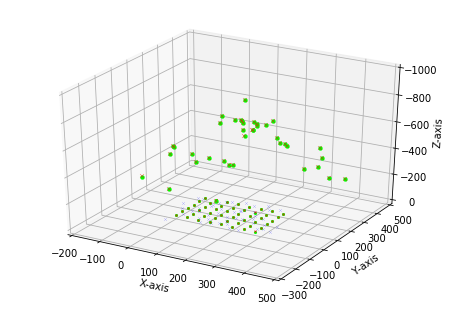

In [12]:
#真のカメラ位置
inv_t = []
for r, t in zip(g_Rs, g_Ts):
    tmp_t = invM(generateM(r, t))[0:3, 3]
    inv_t.append(tmp_t)
g_camera_pos = np.array(inv_t).T

#カメラ位置（誤差あり）    
inv_t = []
for m in est_M:
    tmp_t = invM(m)[0:3, 3]
    inv_t.append(tmp_t)
est_camera_pos = np.array(inv_t).T

# グラフ作成
fig = plt.figure()
ax = Axes3D(fig)

# 軸ラベルの設定
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

ax.set_xlim(-200, 500)
ax.set_ylim(-300, 500)
ax.set_zlim(10, -1000)

# グラフ描画
ax.plot(obj[0,:], obj[1,:], obj[2,:], "o", color="#00ff00", ms=3, mew=0.1)
ax.plot(obs[0,:], obs[1,:], obs[2,:], "x", color="#0000ff", ms=3, mew=0.1)
ax.plot(est_obj[0,:], est_obj[1,:], est_obj[2,:], "x", color="#ff0000", ms=2, mew=0.5)

ax.plot(est_camera_pos[0,:], est_camera_pos[1,:], est_camera_pos[2,:], "o", color="#00ff00", ms=4, mew=0.3)
ax.plot(g_camera_pos[0,:], g_camera_pos[1,:], g_camera_pos[2,:], "x", color="#ff0000", ms=4, mew=0.3)
#ax.plot(obs_camera_pos[0,:], obs_camera_pos[1,:], obs_camera_pos[2,:], "x", color="#0000ff", ms=4, mew=0.2)

plt.show()

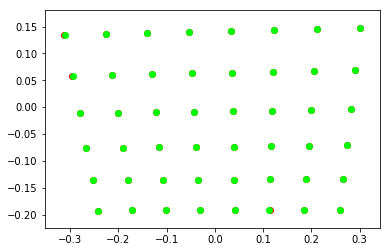

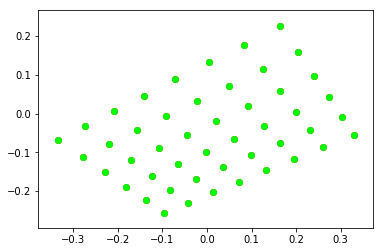

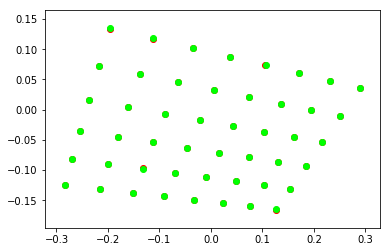

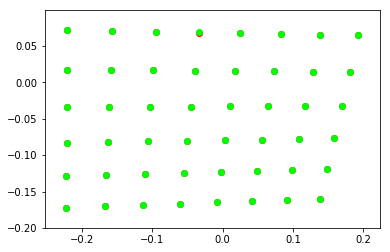

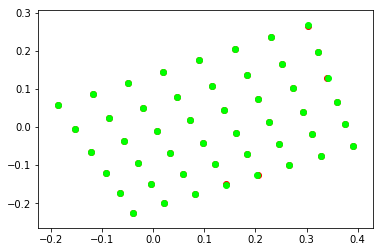

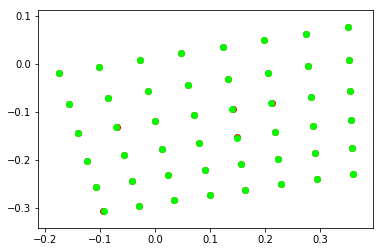

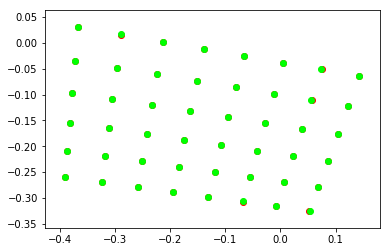

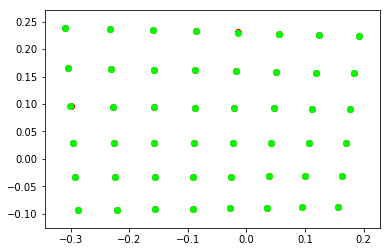

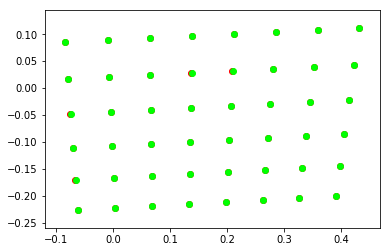

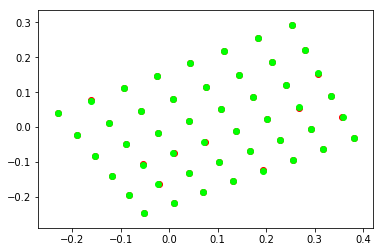

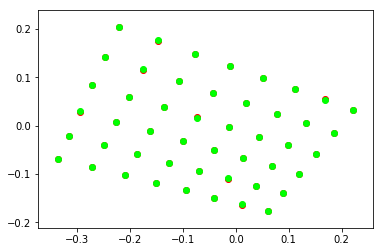

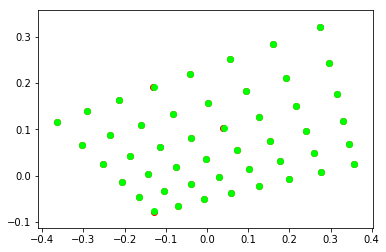

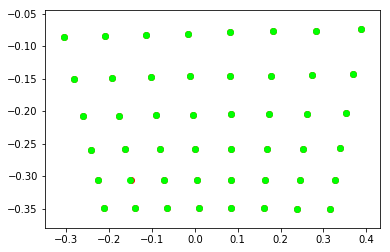

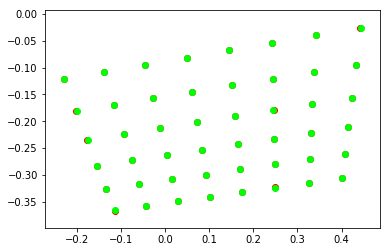

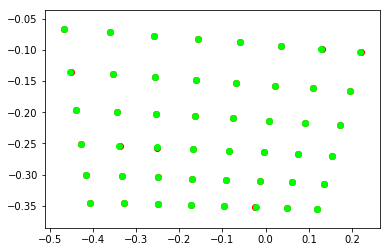

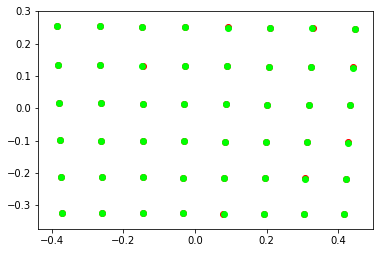

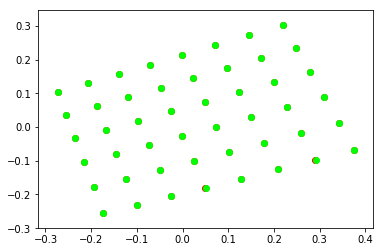

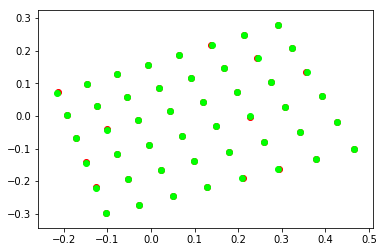

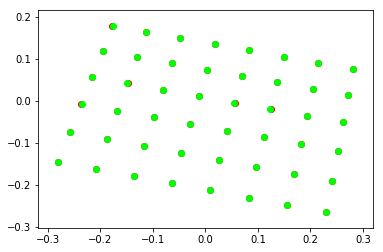

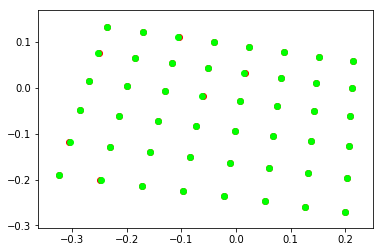

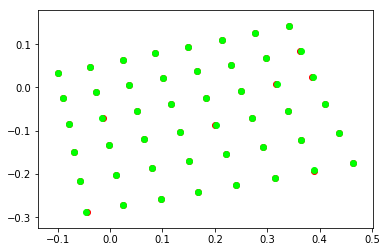

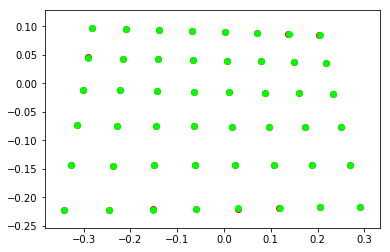

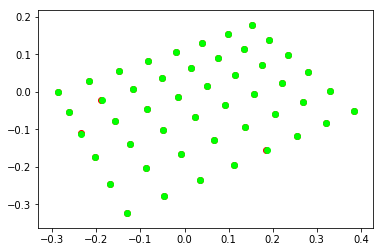

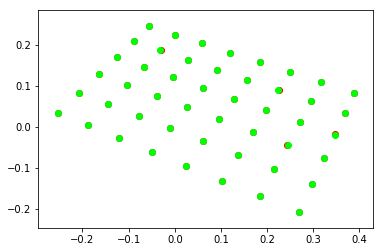

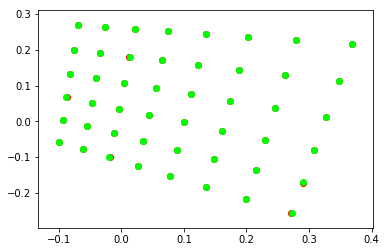

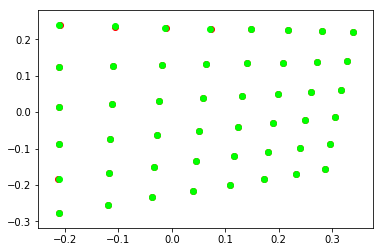

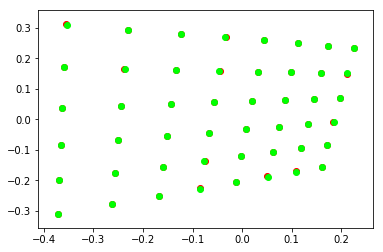

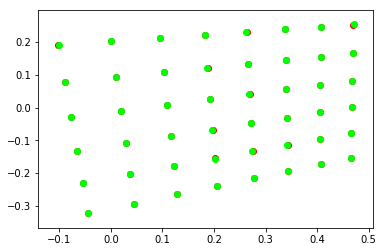

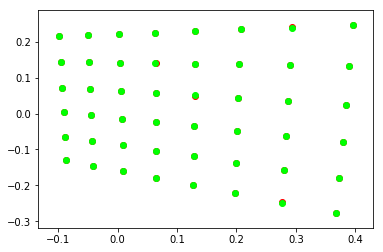

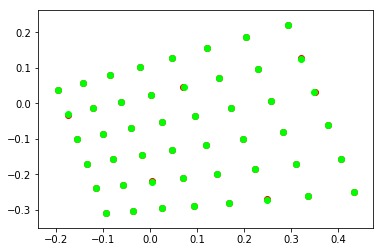

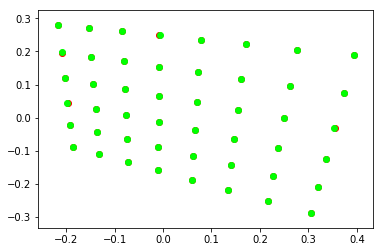

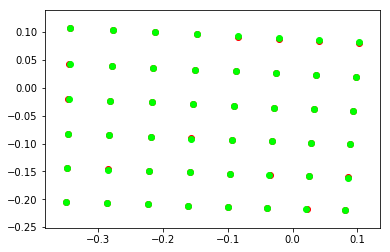

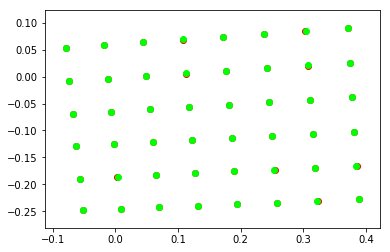

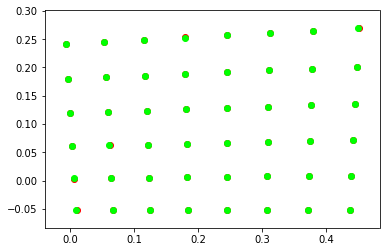

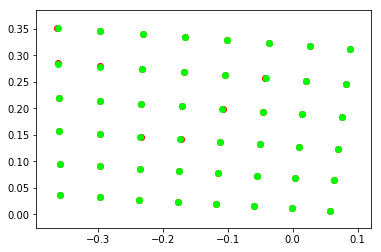

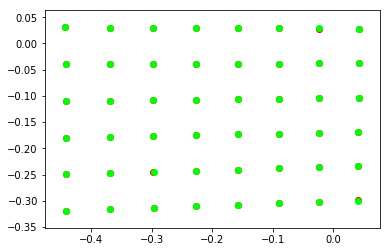

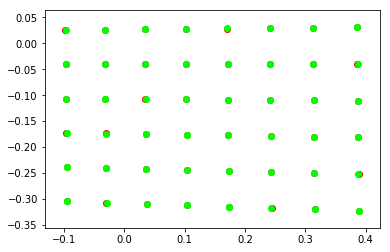

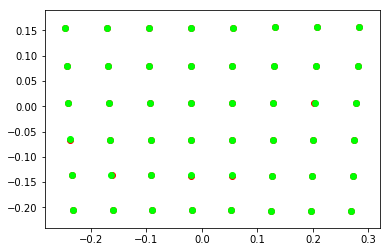

In [13]:
#推定した三次元位置、カメラ位置を投影する例
for i in range(num_camera):
    tmp_cam_num = i
    pos2d = get_proj_pos(est_obj, est_M[tmp_cam_num])
    plt.scatter(norm_img_points[tmp_cam_num][:,0],norm_img_points[tmp_cam_num][:,1],color="#ff0000")
    plt.scatter(pos2d[0,:],pos2d[1,:], color="#00ff00")
    plt.show()

In [14]:
err = 0
err_est = 0
for i in range(num_obj):
    dx = obj[:,i] - obs[:,i]
    err += math.sqrt(dx.T.dot(dx))
    dx2 = obj[:,i] - est_obj[:,i]
    err_est += math.sqrt(dx2.T.dot(dx2))
print (err)
print (err_est)

1670.0582853534345
8.37752467324599


 * Copyright (c) 2018, tmako123
 * https://twitter.com/tmako123
 * http://blog.livedoor.jp/tmako123-programming/
 * All rights reserved.
 * This file is distributed under the GNU Lesser General Public License v3.0.
 * The complete license agreement can be obtained at:
 * http://www.gnu.org/licenses/lgpl-3.0.html